#### Import the necessary libraries

In [191]:
import warnings
import datetime
import pandas as pd
import numpy as np
import numpy as np
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
from ta.utils import dropna
from ta import add_all_ta_features
from sklearn import preprocessing, svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import time
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector, VarianceThreshold, RFE, RFECV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb 
from sklearn.svm import SVC
from sklearn.datasets import make_classification, load_digits
import groupProjectHelpers as gph


warnings.simplefilter('ignore', FutureWarning)

#### ---------------------------------------------------------------------------------------------------------------------------

#### Obtain the info for the SPY ticker

The SPY ticker data was obtained directly from the yahoo finance website below.  The data contains values (Open, High, Low, Close, Volume) for days from 2017-01-01, until 2022-02-18.  

#### Retrieving a single ticker

References: https://handsoffinvesting.com/get-40-technical-indicators-for-a-stock-using-python/
            https://analyzingalpha.com/blog/yfinance-python

In [99]:
stock_info = yf.Ticker('SPY')
hist_data = stock_info.history(start = '2017-01-01', end = '2022-02-18')
hist_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-03,205.326588,206.047392,204.268214,205.509079,91366500,0.0,0
2017-01-04,205.855825,206.886842,205.846706,206.731735,78744400,0.0,0
2017-01-05,206.448857,206.731698,205.728052,206.567459,78379000,0.0,0
2017-01-06,206.686125,207.799255,206.111308,207.306564,71559900,0.0,0
2017-01-09,207.032831,207.178818,206.585750,206.622253,46939700,0.0,0
...,...,...,...,...,...,...,...
2022-02-11,448.018180,450.211349,437.580605,439.095886,153214600,0.0,0
2022-02-14,438.557576,440.232366,433.991744,437.660339,123006300,0.0,0
2022-02-15,442.355790,444.897880,441.807475,444.718445,88482700,0.0,0


#### Create Features (Explore technical indicators)

Technical indicators were obtained for the SPY ticker.  Technical indicators are exploratory variables that can are derived from a security's price, volume and or open.  They are often used to find patterns of movement within that can be exploited for potential gain. 

Using the ta library, over 80 different techncial indicators were obtained, with the intentions of reducing the number to include only the five of greatest importance.  These indicators were used as our features for predictions.   

Reference: https://medium.com/analytics-vidhya/python-for-stock-analysis-fcff252ca559
           https://technical-analysis-library-in-python.readthedocs.io/en/latest/


In [100]:
mom_data = add_all_ta_features(hist_data, open="Open", high="High", low="Low", 
                               close="Close", volume="Volume")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

C:\Users\kthom\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\kthom\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [101]:
mom_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,205.326588,206.047392,204.268214,205.509079,91366500,0.0,0,3.607831e+07,91366500,NaN,NaN,NaN,NaN,-2.947704e+07,NaN,NaN,1000.000000,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,207.054073,203.495717,NaN,0.565812,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.157803,NaN,0.000000,0.000000,0.000000,NaN,302.003713,295.600517,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-32.159365,NaN,0.000000
2017-01-04,205.855825,206.886842,205.846706,206.731735,78744400,0.0,0,9.133778e+07,170110900,NaN,NaN,1.596932,NaN,-2.891440e+07,NaN,NaN,1005.949403,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,207.291318,204.472004,NaN,0.801518,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.577528,NaN,0.000000,0.000000,0.000000,NaN,302.003713,295.600517,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.594940,0.593177,0.594940
2017-01-05,206.448857,206.731698,205.728052,206.567459,78379000,0.0,0,1.440645e+08,91731900,NaN,NaN,-0.175299,NaN,4.061995e+05,NaN,NaN,1005.150041,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,207.309562,204.760922,NaN,0.708824,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.577528,NaN,0.000000,0.000000,0.000000,NaN,302.003713,295.600517,NaN,NaN,NaN,NaN,206.047392,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.079463,-0.079495,0.515004
2017-01-06,206.686125,207.799255,206.111308,207.306564,71559900,0.0,0,1.738495e+08,163291800,NaN,NaN,1.711079,NaN,1.937611e+05,NaN,NaN,1008.746501,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,207.672252,204.916799,NaN,0.867286,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.033734,NaN,0.000000,0.000000,0.000000,NaN,302.003713,295.600517,NaN,NaN,NaN,205.728052,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.357803,0.357165,0.874650
2017-01-09,207.032831,207.178818,206.585750,206.622253,46939700,0.0,0,1.326882e+08,116352100,NaN,NaN,-0.092230,NaN,1.010976e+05,NaN,NaN,1005.416668,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,207.615537,205.173946,NaN,0.593182,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.033734,NaN,0.000000,0.000000,0.000000,NaN,302.003713,295.600517,NaN,NaN,NaN,205.728052,NaN,0.0,0.0

The technical indicators were used to predict ETF movement for a period of 7 days. If the 7 day performance ('Target') was expected to be a positive percent increase, a value ('Target Direction') of 1 was assigned, if the performance was expected to be negative or zero, a target of zero was assigned. 

####  Create 7 day average profit/loss column and a 7 day target column.

References: https://towardsdatascience.com/implementation-of-technical-indicators-into-a-machine-learning-framework-for-quantitative-trading-44a05be8e06

#### Drop unused columns

In [102]:
# These columns are missing large amounts of data
df_1 = mom_data.drop(columns = ['Dividends', 'Stock Splits', 'volatility_bbhi', 'volatility_bbli', 
                                'volatility_kchi', 'volatility_kcli', 'trend_psar_up_indicator', 
                               'trend_psar_down_indicator'])

In [103]:
df_1.head(10)

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,205.326588,206.047392,204.268214,205.509079,91366500,3.607831e+07,91366500,NaN,NaN,NaN,NaN,-2.947704e+07,NaN,NaN,1000.000000,NaN,NaN,NaN,NaN,NaN,NaN,207.054073,203.495717,NaN,0.565812,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.157803,NaN,0.0,0.0,0.0,NaN,302.003713,295.600517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-32.159365,NaN,0.000000
2017-01-04,205.855825,206.886842,205.846706,206.731735,78744400,9.133778e+07,170110900,NaN,NaN,1.596932,NaN,-2.891440e+07,NaN,NaN,1005.949403,NaN,NaN,NaN,NaN,NaN,NaN,207.291318,204.472004,NaN,0.801518,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.577528,NaN,0.0,0.0,0.0,NaN,302.003713,295.600517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.594940,0.593177,0.594940
2017-01-05,206.448857,206.731698,205.728052,206.567459,78379000,1.440645e+08,91731900,NaN,NaN,-0.175299,NaN,4.061995e+05,NaN,NaN,1005.150041,NaN,NaN,NaN,NaN,NaN,NaN,207.309562,204.760922,NaN,0.708824,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.577528,NaN,0.0,0.0,0.0,NaN,302.003713,295.600517,NaN,NaN,NaN,NaN,206.047392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.079463,-0.079495,0.515004
2017-01-06,206.686125,207.799255,206.111308,207.306564,71559900,1.738495e+08,163291800,NaN,NaN,1.711079,NaN,1.937611e+05,NaN,NaN,1008.746501,NaN,NaN,NaN,NaN,NaN,NaN,207.672252,204.916799,NaN,0.867286,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.033734,NaN,0.0,0.0,0.0,NaN,302.003713,295.600517,NaN,NaN,NaN,205.728052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.357803,0.357165,0.874650
2017-01-09,207.032831,207.178818,206.585750,206.622253,46939700,1.326882e+08,116352100,NaN,NaN,-0.092230,NaN,1.010976e+05,NaN,NaN,1005.416668,NaN,NaN,NaN,NaN,NaN,NaN,207.615537,205.173946,NaN,0.593182,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.033734,NaN,0.0,0.0,0.0,NaN,302.003713,295.600517,NaN,NaN,NaN,205.728052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.330096,-0.330642,0.541667
2017-01-10,206.640491,207.525521,206.211662,206.622253,63771900,1.087747e+08,180124000,NaN,NaN,-0.028210,NaN,-1.549461e+05,NaN,NaN,1005.416668,NaN,NaN,NaN,NaN,NaN,NaN,207.696337,205.223725,NaN,0.565608,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [104]:
# The close is shifted by 6 to account for the indicators performance expected for the next seven day, but
# buying on the next day.  
mom_data['Close_Shifted'] = mom_data['Close'].transform(lambda x: x.shift(-6))
mom_data['Target'] = ((mom_data['Close_Shifted'] - mom_data['Open'])/(mom_data['Open']) * 100).shift(-1)
# A value of 0 or 1 is assigned based on anticiapated performance for the next 7 days.  
mom_data['Target_Direction'] = np.where(mom_data['Target']>0, 1, 0)

#### Fill in empty cells

In [105]:
# Fill empy cells with zero
df_2 = mom_data.fillna(0)

In [106]:
df_2.shape

(1292, 96)

In [107]:
df_2.head(10)

                  Open        High         Low       Close     Volume  \
Date                                                                    
2017-01-03  205.326588  206.047392  204.268214  205.509079   91366500   
2017-01-04  205.855825  206.886842  205.846706  206.731735   78744400   
2017-01-05  206.448857  206.731698  205.728052  206.567459   78379000   
2017-01-06  206.686125  207.799255  206.111308  207.306564   71559900   
2017-01-09  207.032831  207.178818  206.585750  206.622253   46939700   
...                ...         ...         ...         ...        ...   
2022-02-11  448.018180  450.211349  437.580605  439.095886  153214600   
2022-02-14  438.557576  440.232366  433.991744  437.660339  123006300   
2022-02-15  442.355790  444.897880  441.807475  444.718445   88482700   
2022-02-16  442.555144  446.672358  440.571317  445.216888   84863600   
2022-02-17  441.847347  445.186978  435.068419  435.706421  102259100   

            Dividends  Stock Splits    volume_adi 

### Data exploration

#### Check for multicollinearity using correlation table and heatmap

Over 80 different technical indicators were part of the initial dataset.  It was decided to choose the top 5 indicators for modeling.  

In [108]:
# Correlation heatmap
corr = df_2.corr()

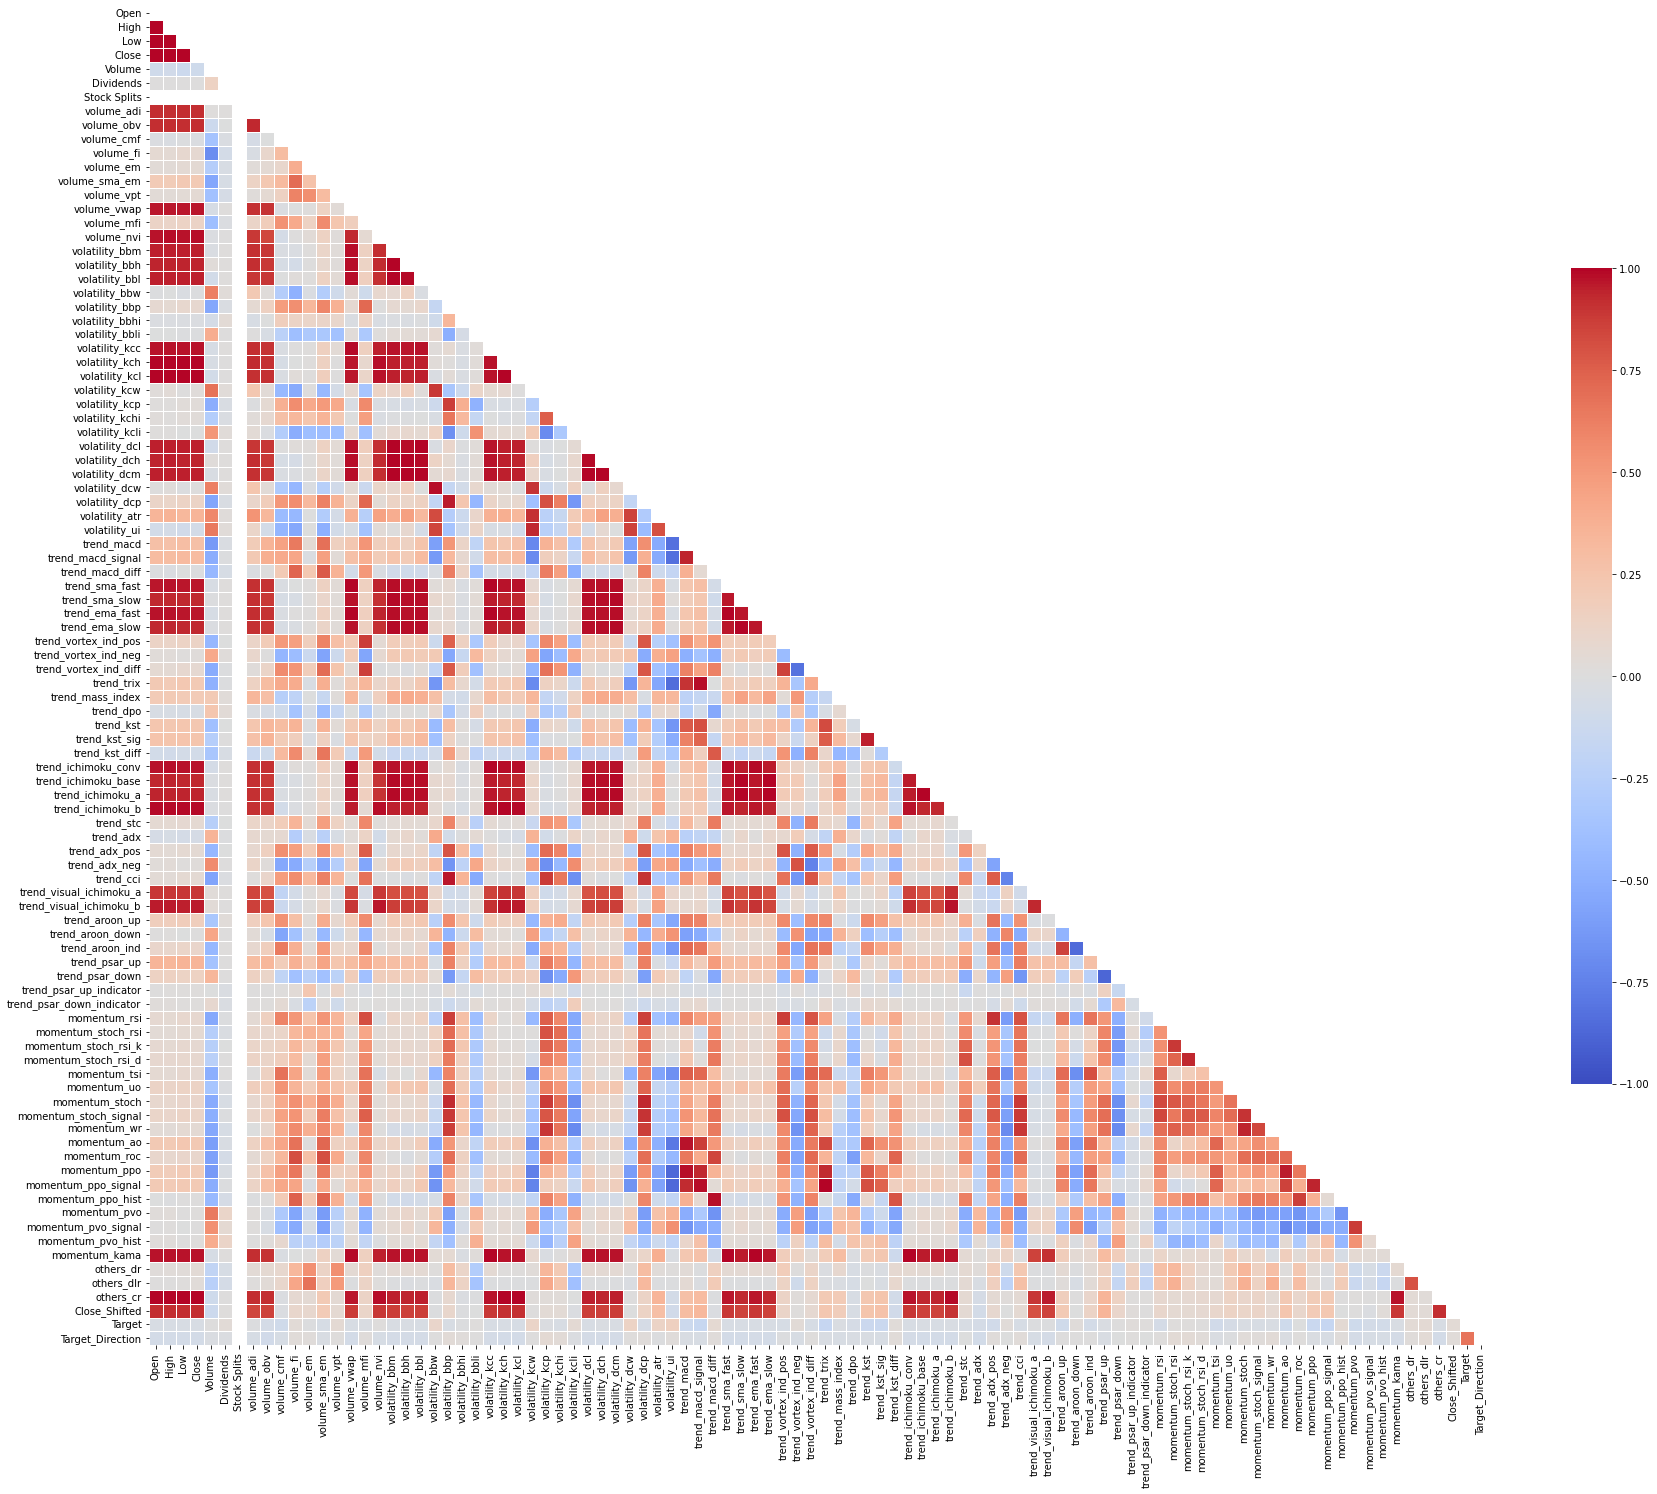

In [109]:
# Create the mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype = bool))

# Setup the figure
f, ax = plt.subplots(figsize =(30, 30))

# Create the color palette
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw heatmap
sns.heatmap(corr, mask=mask, vmin =0-1, vmax = 1, cmap = cmap, 
           square=True, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

Time series data has certain requirements before machine learning modeling can be applied.  Among the requirements include: trend analysis, outlier detection and stationary testing.  

#### Check the trend of the data

The trend of the data represents movement of the data to relatively higher or lower values over a long period of time.  Trends are generally considered to be one of the following: 
- Upward: Trend generally goes in the upward direction
- Downward: Trend goes downward
- Horizontal or Stationary:  No pattern is observed.  

In the plot below for the variable, "Target", the black line represents the actual values, the red line represents the 7 day moving average and the blue shading represents the bollinger band (standard deviations above and below the moving average).  

For the given time frame, the trend appears to be horizontal/stationary.  

In [110]:
# Create a dataframe with the date
ts = df_2.loc[:, ["Target"]]

C:\Users\kthom\Desktop\Grad School\Data Science MSc\DSC 478\Group Project\groupProjectHelpers.py:179: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


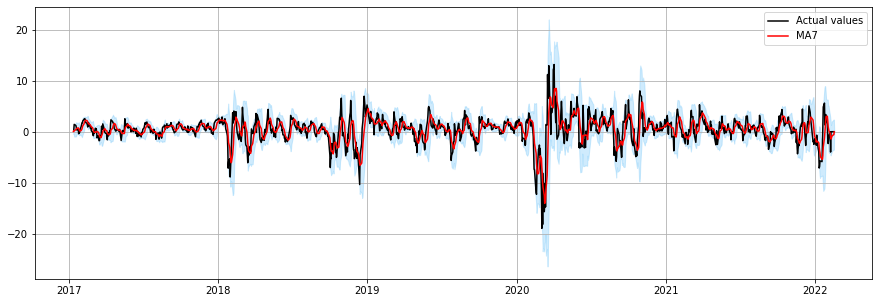

In [111]:
# Reference: https://towardsdatascience.com/time-series-analysis-for-machine-learning-with-python-626bee0d0205
gph.plot_ts(ts, window=7)

The histogram below suggests that that the data is approximately normally distributed, with the mean slightly in the positive percentage range.  Several outliers are present in both the positive and negative percentage ranges.  

array([[<AxesSubplot:title={'center':'Target'}>]], dtype=object)

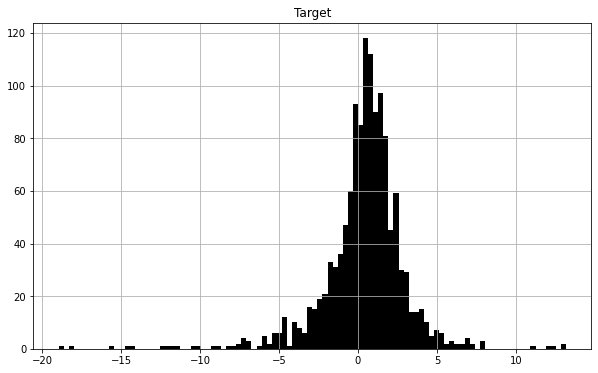

In [112]:
ts.hist(color="black", bins = 100)

#### Check for outliers

In the plot below, outliers are identified for values outside of approximately two standard deviations from the mean.  After the outliers were identified, the values are filled using interpolation.  

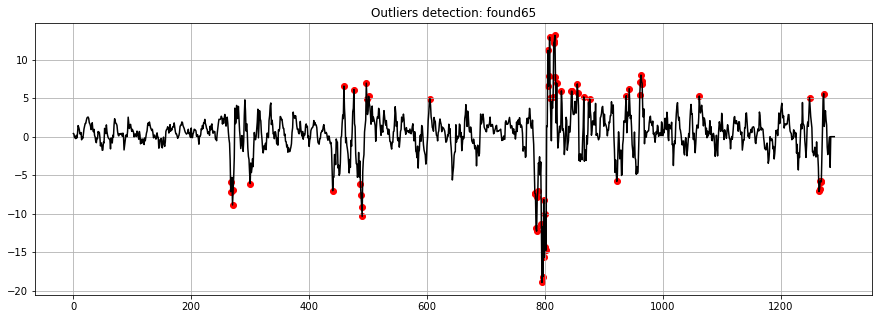

In [113]:
dtf_outliers = gph.find_outliers(ts, perc=0.05)

#### Remove outliers

The plot below shows the data plotted before the outliers were removed (red) vs. after the outliers were removed (black).  

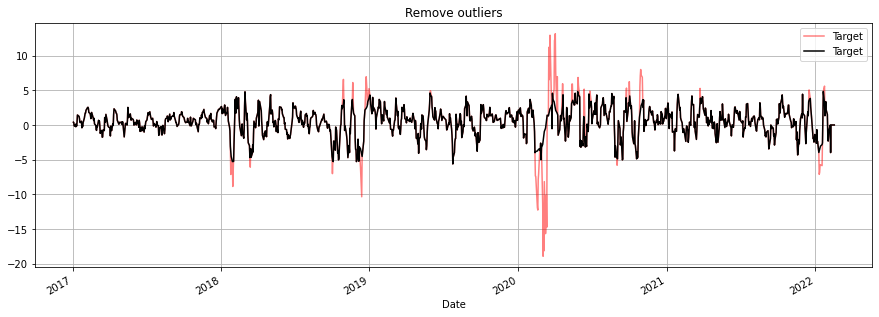

In [114]:
# Outliers index position
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index

# Exclude outliers 
ts_clean = gph.remove_outliers(ts, outliers_idx=outliers_index_pos)

#### Add the new Target to the dataframe

In [115]:
df_2['Target'] = ts_clean

#### Check to ensure that data is stationary by checking for autocorrelation

One aspect to consider when dealing with time series autocorrelation.  Autocorrelation represents the influence of previously observed values on a current observation and is sometimes referred to as serial correlation.  For machine learning models, autocorrelation should generally be avoided.  In the chart below the autocorrelation significance is shown for 50 consecutive points.  The shaded blue area represents a signifcance value of 95%.  Points risding outside of the blue area are considered to be serial correlated.  For our dataset, autocorrelation occurs for 6 consecutive data points, which is considered to be acceptable.  

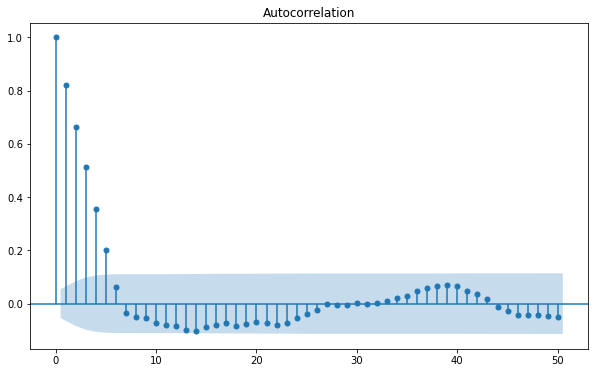

In [116]:
#Reference: https://www.alpharithms.com/autocorrelation-time-series-python-432909/#:~:text=Autocorrelation%20(ACF)%20is%20a%20calculated,values%20in%20time%20series%20data.

# Use the Autocorrelation function
# from the statsmodel library passing
# our DataFrame object in as the data
# Note: Limiting Lags to 50

plt.rcParams["figure.figsize"] = 10, 6

plot_acf(df_2['Target'], lags=50)
# Show the AR as a plot
plt.show()

The autocorrelation indicates that beyond 6 days there is no significant correlation with the most recent Target value.  

In [117]:
df_2.to_csv('full_data.csv')

#### --------------------------------------------------------------------------------------------------------

#### Create training and validation and testing sets

#### Standardize the data

The data was first normalized using z-score normalization.  

In [118]:
y = df_2['Target_Direction']
X = df_2.drop(columns = ['Target_Direction', 'Target', 'Close_Shifted'])

ss = StandardScaler()
scaled_features = ss.fit_transform(X)

#### Determine the number of features to keep

The number of technical indicators needed to be reduced from 93 to 5.  In order to accomplish this recursive feature elimination (RFE) was applied to the features.  The estimator used to facilitate the RFE was a random forest classifier.  

In [119]:
# Reference: https://towardsdatascience.com/5-feature-selection-method-from-scikit-learn-you-should-know-ed4d116e4172
# Use recursive feature Elimination (RFE) to select features
rfe_selector = RFE(estimator=RandomForestClassifier(),n_features_to_select = 5, step = 1)
rfe_selector.fit(scaled_features, y)
selected_features = X.columns[rfe_selector.get_support()]

In [120]:
selected_features

Index(['volume_adi', 'volume_vwap', 'volume_nvi', 'trend_sma_slow',
       'trend_visual_ichimoku_a'],
      dtype='object')

#### Drop rows containing zero

In [121]:
# Create a dataframe using the selected features.
reduced_features = df_2[selected_features]

reduced_features2 = reduced_features[(reduced_features != 0).all(axis=1)]

# Transform the data.  
scaled_features = ss.fit_transform(reduced_features2)

#### Split into training and testing data

Due to the fact that for any observation within a time series dataset, there exists dependency with other points, the train_test_split method cannot be applied to the training and testing sets.  This could result in training the model on data that occurs after the testing data.  Instead, the data is split into older dates (training), that will be used to train the model and recent dates (testing), that will be used to test the the model.  

In [122]:
# Split into train test split

X_train = np.array(reduced_features[:'2022-01-01'])
y_train = np.array(y[:'2022-01-01'])

X_test = np.array(reduced_features['2022-01-02':])
y_test = np.array(y['2022-01-02':])

#### Cross validation

Like with the training and testing data, k-fold cross validation cannot be used for training the model.  Instead, the function TimeSeriesSplit is used.  TimeSeriesSplit partitions the data in a way where the order of occurrence is preserved and the training data always precedes the test data.  

In [123]:
# Conditions for cross_validation
n_splits = 10
tscv = TimeSeriesSplit(n_splits = n_splits)

#### -----------------------------------------------------------------------------------------------------------------------------

### Machine Learning Models

Four different machine learning models were applied to the training data: 
- Random Forest Classifier
- Gradient Boost Classifier
- K Nearest Neighbors
- XGBoost

For each of the machine learning models the following steps were applied. 
- Paramaters of interest and a grid search was applied. 
- 10 Fold Cross-validaiton was performed using the TimeSeriesSplit function on the training set.  
- A scores was obtained using the Area Under the Curve ROC metric and the best parameters were obtained.
- The best parameters were applied using the test set.  
- Both a confusion matrix and metrics classification report were obtained.  

#### Use Random Forest with reduced set 

In [192]:
params = dict(min_samples_split = [2, 5, 10, 15, 30],
             min_samples_leaf = [2, 5, 10, 15, 30], 
             max_depth = [5, 10, 15, 20])
rf = RandomForestClassifier()

In [193]:
gph.cross_val_classifier(rf, X_train, y_train, params, tscv, 'roc_auc')

Fitting 10 folds for each of 30 candidates, totalling 300 fits
The total run time: 1.0261927564938864 mins
The best parameters are: {'min_samples_split': 15, 'min_samples_leaf': 10, 'max_depth': 20}
The best scores is: 0.5542536009598557






#### Implement the best parameters on the reduced validation set 

In [210]:
rf = RandomForestClassifier(min_samples_split=15, min_samples_leaf=10, max_depth=20)

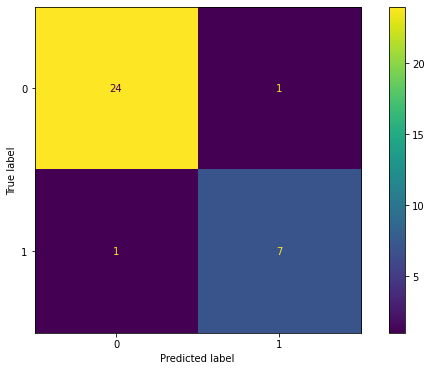

<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       0.88      0.88      0.88         8

    accuracy                           0.94        33
   macro avg       0.92      0.92      0.92        33
weighted avg       0.94      0.94      0.94        33

The total run time: 0.007744415601094564 mins


In [211]:
gph.cm_matrix_score(rf, X_train, y_train, X_test, y_test)

#### Use Gradient Boost Classifier with reduced set

In [196]:
params = dict(learning_rate = [0.1, 0.2, 0.3],
             n_estimators = [200, 300],
             min_samples_split = [2, 5, 10, 25],
             max_depth = [10, 20, 30])
gb = GradientBoostingClassifier()

In [197]:
gph.cross_val_classifier(gb, X_train, y_train, params, tscv, 'roc_auc')

Fitting 10 folds for each of 30 candidates, totalling 300 fits
The total run time: 5.341533827781677 mins
The best parameters are: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 30, 'learning_rate': 0.3}
The best scores is: 0.5159837212967384






#### Apply the Best Parameters to the validation set

In [212]:
gb = GradientBoostingClassifier(n_estimators=200, min_samples_split = 2, max_depth = 30, learning_rate=.3)

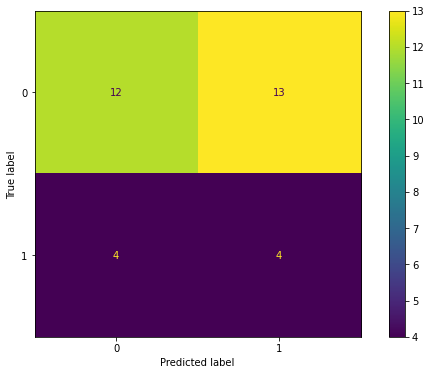

<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.75      0.48      0.59        25
           1       0.24      0.50      0.32         8

    accuracy                           0.48        33
   macro avg       0.49      0.49      0.45        33
weighted avg       0.63      0.48      0.52        33

The total run time: 0.015147813161214193 mins


In [213]:
gph.cm_matrix_score(gb, X_train, y_train, X_test, y_test)

#### Use KNN with reduced dataset

In [200]:
params = dict(n_neighbors = [5, 10, 15, 20, 25, 30, 50, 100], 
             weights = ['uniform', 'distance'])

In [201]:
knn = KNeighborsClassifier()

In [202]:
gph.cross_val_classifier(knn, X_train, y_train, params, tscv, 'roc_auc')

Fitting 10 folds for each of 16 candidates, totalling 160 fits


C:\Users\kthom\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=30. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


The total run time: 0.01384723981221517 mins
The best parameters are: {'weights': 'distance', 'n_neighbors': 100}
The best scores is: 0.5521321158486339






#### Apply the Best Parameters to the validation set

In [203]:
knn = KNeighborsClassifier(weights='distance', n_neighbors=100)

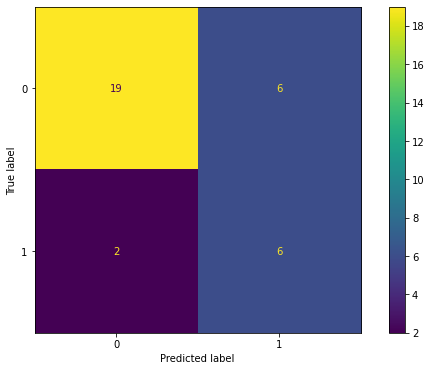

<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.90      0.76      0.83        25
           1       0.50      0.75      0.60         8

    accuracy                           0.76        33
   macro avg       0.70      0.76      0.71        33
weighted avg       0.81      0.76      0.77        33

The total run time: 0.003357815742492676 mins


In [204]:
gph.cm_matrix_score(knn, X_train, y_train, X_test, y_test)

#### Use XGBoost

In [205]:
params = dict(learning_rate = [0.1, 0.2, 0.3],
             max_depth = [10, 20, 30],
             colsample_bytree = [0.5, 1],
             reg_lambda = [0.25, 0.5, 0.75, 1])

In [206]:
xgb_class = xgb.XGBClassifier(objective = 'binary:hinge', use_label_encoder=False)

In [207]:
gph.cross_val_classifier(xgb_class, X_train, y_train, params, tscv, 'roc_auc')

Fitting 10 folds for each of 30 candidates, totalling 300 fits
The total run time: 0.5675777792930603 mins
The best parameters are: {'reg_lambda': 1, 'max_depth': 10, 'learning_rate': 0.3, 'colsample_bytree': 0.5}
The best scores is: 0.5350999546466337






#### ------------------------------------------------------------------------------------------------------------------

#### Apply the best parameters to the test set

In [214]:
xgb_class = xgb.XGBClassifier(objective = 'binary:hinge', use_label_encoder=False,
                             max_depth = 10, learning_rate = 0.3, colsample_bytree = 0.5, reg_lambda = 1)

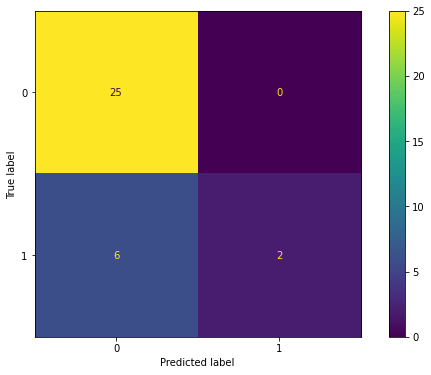

<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        25
           1       1.00      0.25      0.40         8

    accuracy                           0.82        33
   macro avg       0.90      0.62      0.65        33
weighted avg       0.85      0.82      0.77        33

The total run time: 0.006233481566111246 mins


In [215]:
gph.cm_matrix_score(xgb_class, X_train, y_train, X_test, y_test)